# Direct 3-way Classification Between WNT, SHH, and Group3+4 

## Required Imports

In [2]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set()

## Data Preprocessing/Loading 

In [4]:
# load data
file_path = "features.csv"
df = pd.read_csv(file_path)
df.head()

,case,molecular,split,sex,age,t1_diagnostics_Versions_PyRadiomics,t1_diagnostics_Versions_Numpy,t1_diagnostics_Versions_SimpleITK,t1_diagnostics_Versions_PyWavelet,t1_diagnostics_Versions_Python,...,t2_wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,t2_wavelet-LLL_glszm_SizeZoneNonUniformity,t2_wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,t2_wavelet-LLL_glszm_SmallAreaEmphasis,t2_wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,t2_wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,t2_wavelet-LLL_glszm_ZoneEntropy,t2_wavelet-LLL_glszm_ZonePercentage,t2_wavelet-LLL_glszm_ZoneVariance
0,212716,shh,1,F,35.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,0.026191,0.000914,2512.151097,0.393754,0.651604,1918.935163,0.000685,8.103643,0.364780,73.645028
1,220204,group4,2,M,22.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,0.045723,0.002111,2670.044883,0.435783,0.686319,1419.813827,0.001417,7.934767,0.433004,18.896570
2,234406,group4,4,M,26.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,0.015780,0.001037,2894.365780,0.396815,0.654527,1759.160320,0.000632,8.058357,0.405493,17.069254
3,243030,shh,3,M,34.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,1.771472,0.000828,3931.643936,0.403784,0.660745,2215.427751,0.000581,8.079126,0.175195,8279.544143
4,248063,shh,0,M,37.0,v3.0.1,1.24.3,2.2.1,1.4.1,3.10.10,...,0.617026,0.001642,1492.182540,0.370085,0.631286,848.080953,0.001149,7.561874,0.257143,613.609678


In [5]:
# obtain list of features selected from LASSO
# reduced_feats_path = "/Users/samwwong/Desktop/Michael Zhang/reduced_molec.xlsx"
# reduced_features = pd.read_excel(reduced_feats_path)
# reduced_features_list = reduced_features.loc[reduced_features['3way'].isnull() == False, 
#                                              ['3way']].values.tolist()
# reduced_features_list = [item for sublist in reduced_features_list for item in sublist]
# print(reduced_features_list)
reduced_features_list = ['sex', 't1_log-sigma-3-mm-3D_firstorder_Median', 't1_original_glrlm_LowGrayLevelRunEmphasis', 't1_original_shape_Flatness', 't1_wavelet-HLL_glcm_Correlation', 't1_wavelet-LLL_firstorder_Skewness', 't2_log-sigma-1-mm-3D_firstorder_Mean', 't2_log-sigma-1-mm-3D_firstorder_Median', 't2_log-sigma-5-mm-3D_firstorder_Kurtosis', 't2_log-sigma-5-mm-3D_glszm_SmallAreaEmphasis', 't2_original_glszm_GrayLevelNonUniformity', 't2_wavelet-HHH_glszm_SmallAreaLowGrayLevelEmphasis', 't2_wavelet-HHL_glcm_ClusterProminence', 't2_wavelet-HHL_glrlm_LongRunHighGrayLevelEmphasis', 't2_wavelet-HLL_firstorder_Mean', 't2_wavelet-LHH_glszm_GrayLevelNonUniformityNormalized', 't2_wavelet-LLL_glcm_JointAverage', 't2_wavelet-LHL_glcm_Idn', 't2_wavelet-LHL_glcm_Idmn', 't1_log-sigma-3-mm-3D_glcm_ClusterProminence', 't1_original_glszm_LargeAreaLowGrayLevelEmphasis', 't2_wavelet-HHH_glcm_Id', 't1_wavelet-LLL_glszm_ZoneVariance', 't2_wavelet-LLL_firstorder_Energy', 't2_wavelet-LLL_firstorder_TotalEnergy']

features_after_lasso = df[reduced_features_list]
sex_binarized = features_after_lasso['sex'].map(lambda sex: {'F': 0, 'M': 1}.get(sex, -1)).to_numpy()
features_after_lasso['sex'] = sex_binarized

print(len(reduced_features_list))

25


/tmp/ipykernel_3429891/100540427.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_after_lasso['sex'] = sex_binarized


In [6]:
# Binarizing target
target = df["molecular"]

# Marking 0 as wnt and 1 shh and 2 as group3+4
mapping_dict = {0: 'wnt', 1: 'shh', 2: 'g34'}
target = target.map(dict(wnt = 0, shh = 1, group3 = 2, group4 = 2))
print(target.value_counts())

molecular
2    155
1     82
0     25
Name: count, dtype: int64


In [7]:
# Train/test split
# X_train, X_test, y_train, y_test = train_test_split(features_after_lasso, target, test_size = 0.25, random_state = 42)
test_mask = df['split'] == 'test'
X_train = features_after_lasso[~test_mask]
X_test = features_after_lasso[test_mask]
y_train = target[~test_mask]
y_test = target[test_mask]
print("TRAIN")
print(y_train.value_counts())

print("TEST")
print(y_test.value_counts())

TRAIN
molecular
2    123
1     64
0     15
Name: count, dtype: int64
TEST
molecular
2    32
1    18
0    10
Name: count, dtype: int64


### Resampling to Correct for Imbalance

In [8]:
X = pd.concat([X_train, y_train], axis = 1)
X_0 = X[X['molecular'] == 0] ## wnt
X_1 = X[X['molecular'] == 1] ## shh
X_2 = X[X['molecular'] == 2] ## group3 is highest

In [9]:
upsampled_0 = resample(X_0, replace = True, n_samples = len(X_2), random_state = 42)
upsampled_1 = resample(X_1, replace = True, n_samples = len(X_2), random_state = 42)
upsampled = pd.concat([upsampled_0, upsampled_1, X_2])
upsampled = upsampled.sample(frac = 1, random_state = 42)

In [10]:
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]
print(y_train.value_counts())

molecular
2    123
0    123
1    123
Name: count, dtype: int64


In [11]:
y_train_bin = label_binarize(y_train, classes = [0, 1, 2])
y_test_bin = label_binarize(y_test, classes = [0, 1, 2])

### Standardizing Features

In [12]:
names = X_train.columns
scaler = preprocessing.StandardScaler()

In [13]:
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = names)

In [14]:
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = names)

## Modeling

### User Defined Functions for Metrics

In [15]:
def specificity_score(y_pred, y_true):
    TN = 0
    FP = 0
    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y_true[i] == 0:
            TN += 1
        if y_pred[i] == 1 and y_true[i] == 0:
            FP += 1
    
    return TN / (TN + FP)

In [16]:
def positive_pv_score(y_true, y_pred):
    TP = 0
    FP = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 1:
            TP += 1
        elif y_true[i] == 0 and y_pred[i] == 1:
            FP += 1
    
    return TP/(TP+FP)

In [17]:
def negative_pv_score(y_true, y_pred): ##
    TN = 0
    FN = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i] == 0:
            TN += 1
        elif y_true[i] == 1 and y_pred[i] == 0:
            FN += 1
    
    return TN/(TN+FN) 

In [18]:
def create_ci(bootstrapped_scores, name): ##
    for i in range(3):
        sorted_scores = np.array(bootstrapped_scores)[:, i]
        sorted_scores.sort()
    
        confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    
        print("95% Confidence interval for the {} score for class {}: [{:0.3f} - {:0.3}]".format(name, i,
        confidence_lower, confidence_upper))

In [19]:
def my_classification_report(y_test_np, y_pred):
    import torch
    y_test = torch.from_numpy(y_test_np)
    y_pred = torch.from_numpy(y_pred)
    from torchmetrics import F1Score, Accuracy, Precision, Recall
    for name, metric_cls in [
        ('Precision', Precision),
        ('Recall', Recall),
        ('F1', F1Score),
    ]:
        print(name)
        metric = metric_cls(task='multiclass', num_classes=3, average='none')(y_pred, y_test)
        for i, group in enumerate(['WNT', 'SHH', 'G34']):
            print(group, f'{metric[i].item():.8f}')
        print(f"Macro Avg: {metric.mean().item():.8f}")
    
    print('multiclass acc:', f'{(y_test == y_pred).sum().item() / len(y_test):.8f}')

from typing import Any
def rename_param(param: dict[str, Any]):
    return {
        k[11:]: v
        for k, v in param.items()
    }

### SVM

#### Grid Search for Hyperparameters

In [20]:
svm_model = OneVsRestClassifier(svm.SVC())

In [21]:
grid_param = {'estimator__C': [0.1, 1, 10],
              'estimator__gamma': [1, 0.1, 0.01]
}


svm_grid = GridSearchCV(estimator=svm_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [22]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=OneVsRestClassifier(estimator=SVC()), n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1, 10],
                         'estimator__gamma': [1, 0.1, 0.01]},
             scoring='accuracy')

In [23]:
print(svm_grid.best_params_)

{'estimator__C': 0.1, 'estimator__gamma': 1}


### Model Performance

In [24]:
svm_model = OneVsRestClassifier(svm.SVC(**rename_param(svm_grid.best_params_), probability = True))
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

In [25]:
import torch
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)
def print_auroc(model):
    prob = torch.from_numpy(model.predict_proba(X_test))
    from torchmetrics import AUROC
    auroc = AUROC('multiclass', num_classes=3, average='none')(prob, torch.from_numpy(y_test_np))
    for i, group in enumerate(['WNT', 'SHH', 'G34']):
        print(group, f'{auroc[i].item():.8f}')
    print(f"Macro Avg: {auroc.mean().item():.8f}")

print_auroc(svm_model)

Precision
WNT 0.00000000
SHH 0.00000000
G34 0.53333336
Macro Avg: 0.17777778
Recall
WNT 0.00000000
SHH 0.00000000
G34 1.00000000
Macro Avg: 0.33333334
F1
WNT 0.00000000
SHH 0.00000000
G34 0.69565219
Macro Avg: 0.23188406
multiclass acc: 0.53333333
WNT 0.42200002
SHH 0.76058203
G34 0.69196427
Macro Avg: 0.62484878


In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        18
           2       0.53      1.00      0.70        32

    accuracy                           0.53        60
   macro avg       0.18      0.33      0.23        60
weighted avg       0.28      0.53      0.37        60



/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [27]:
n_classes = 3
svm_model_for_auc = OneVsRestClassifier(svm.SVC(**rename_param(svm_grid.best_params_), probability = True))
y_score = svm_model_for_auc.fit(X_train, y_train_bin).decision_function(X_test)
y_pred_bin = svm_model_for_auc.predict(X_test)

wnt
Accuracy: 0.8333333333333334
auc: 0.428000
shh
Accuracy: 0.7
auc: 0.760582
g34
Accuracy: 0.4666666666666667
auc: 0.591518
Macro-Averaged AUC: 0.593367
Micro-Averaged AUC: 0.7145833333333335


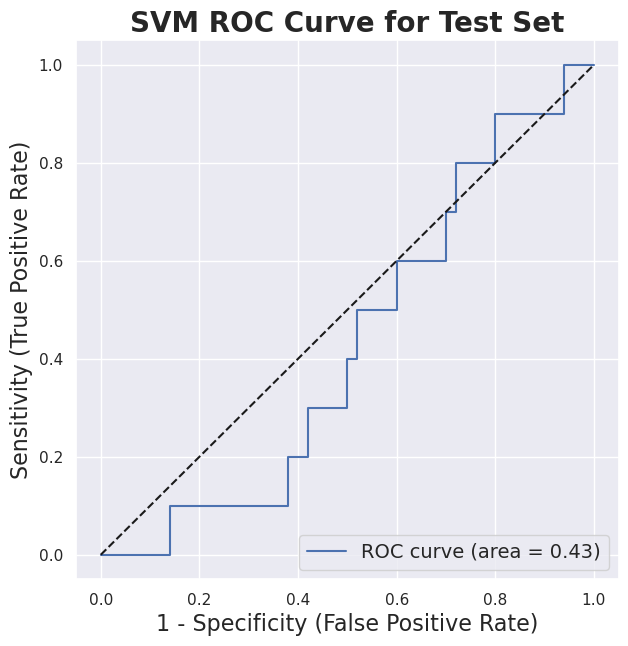

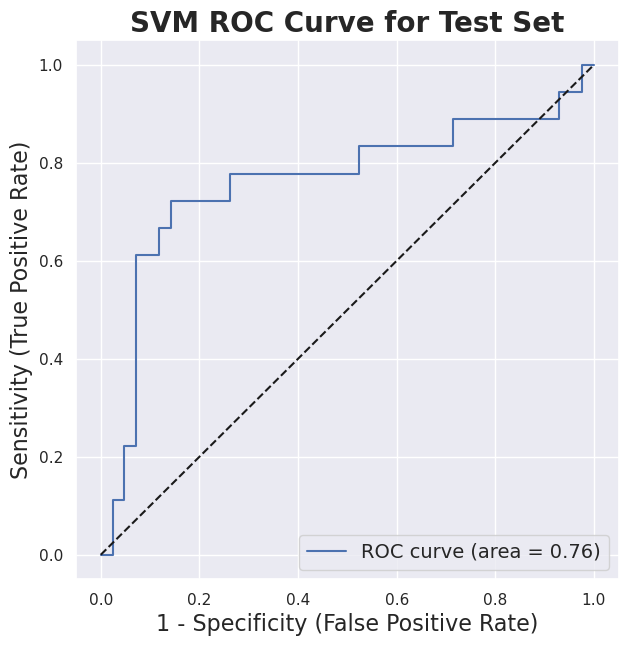

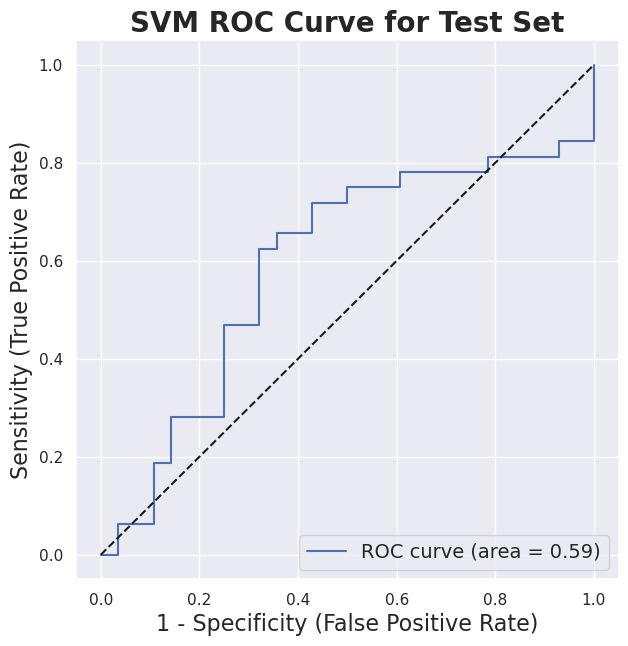

In [34]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    print(f'auc: {roc_auc[i]:.6f}')

print(f"Macro-Averaged AUC: {np.mean(list(roc_auc.values())):.6f}")
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))



# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('SVM ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()


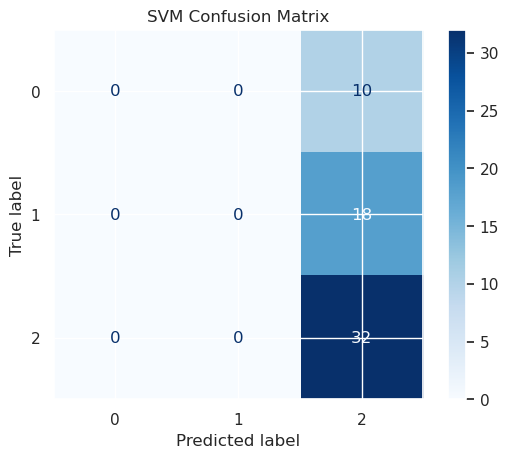

In [29]:
matrix = ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('SVM Confusion Matrix')
plt.show(matrix)
plt.show()

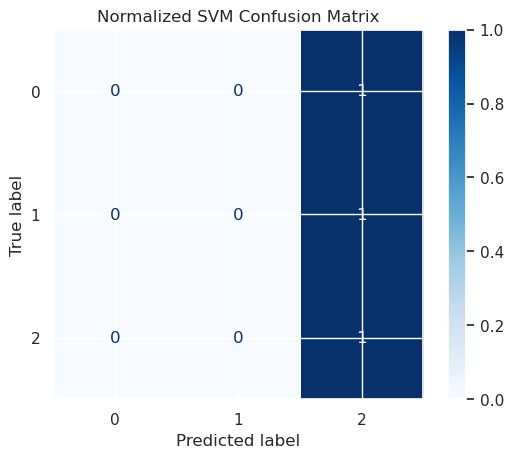

In [30]:
norm_matrix = ConfusionMatrixDisplay.from_estimator(svm_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized SVM Confusion Matrix')
plt.show(matrix)
plt.show()

In [31]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = []
bootstrapped_npv_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = []
    one_npv = []
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))

    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv)
    bootstrapped_npv_scores.append(one_npv)

/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages

KeyboardInterrupt: 

In [ ]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV")
create_ci(bootstrapped_npv_scores, "NPV")

95% Confidence interval for the AUC score for class 0: [0.250 - 0.6]
95% Confidence interval for the AUC score for class 1: [0.583 - 0.913]
95% Confidence interval for the AUC score for class 2: [0.435 - 0.737]
95% Confidence interval for the Accuracy score for class 0: [0.733 - 0.917]
95% Confidence interval for the Accuracy score for class 1: [0.583 - 0.817]
95% Confidence interval for the Accuracy score for class 2: [0.350 - 0.583]
95% Confidence interval for the Specificity score for class 0: [1.000 - 1.0]
95% Confidence interval for the Specificity score for class 1: [1.000 - 1.0]
95% Confidence interval for the Specificity score for class 2: [1.000 - 1.0]
95% Confidence interval for the Precision score for class 0: [0.000 - 0.0]
95% Confidence interval for the Precision score for class 1: [0.000 - 0.0]
95% Confidence interval for the Precision score for class 2: [0.000 - 0.0]
95% Confidence interval for the Recall score for class 0: [0.000 - 0.0]
95% Confidence interval for the R

### Logistic Regression

#### Grid Search for Hyperparameters

In [35]:
lr_model = OneVsRestClassifier(LogisticRegression())
grid_param = {'estimator__penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'estimator__C': [10, 1, 0.1, 0.01, 0.001]
}

lr_grid = GridSearchCV(estimator=lr_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [36]:
lr_grid.fit(X_train, y_train)
print(lr_grid.best_params_)

/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/line

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [10, 1, 0.1, 0.01, 0.001],
                         'estimator__penalty': ['l1', 'l2', 'elasticnet',
                                                'none']},
             scoring='accuracy')

### Model Performance

In [38]:
lr_model = OneVsRestClassifier(LogisticRegression(**rename_param(lr_grid.best_params_)))
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

In [39]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Precision
WNT 0.37500000
SHH 0.90909094
G34 0.70731705
Macro Avg: 0.66380268
Recall
WNT 0.30000001
SHH 0.55555558
G34 0.90625000
Macro Avg: 0.58726853
F1
WNT 0.33333334
SHH 0.68965518
G34 0.79452056
Macro Avg: 0.60583639
multiclass acc: 0.70000000


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.30      0.33        10
           1       0.91      0.56      0.69        18
           2       0.71      0.91      0.79        32

    accuracy                           0.70        60
   macro avg       0.66      0.59      0.61        60
weighted avg       0.71      0.70      0.69        60



In [41]:
n_classes = 3
lr_model_for_auc = OneVsRestClassifier(LogisticRegression(**rename_param(lr_grid.best_params_), random_state = 42))
y_score = lr_model_for_auc.fit(X_train, y_train_bin).decision_function(X_test)
y_pred_bin = lr_model_for_auc.predict(X_test)

wnt
Accuracy: 0.8333333333333334
auc: 0.566000
shh
Accuracy: 0.8333333333333334
auc: 0.755291
g34
Accuracy: 0.6833333333333333
auc: 0.705357
Macro-Averaged AUC: 0.675549
Micro-Averaged ROC: 0.7649999999999999


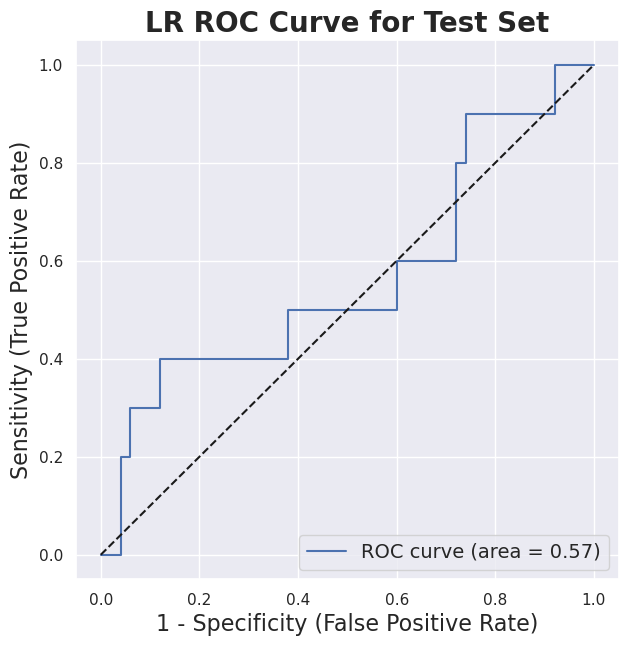

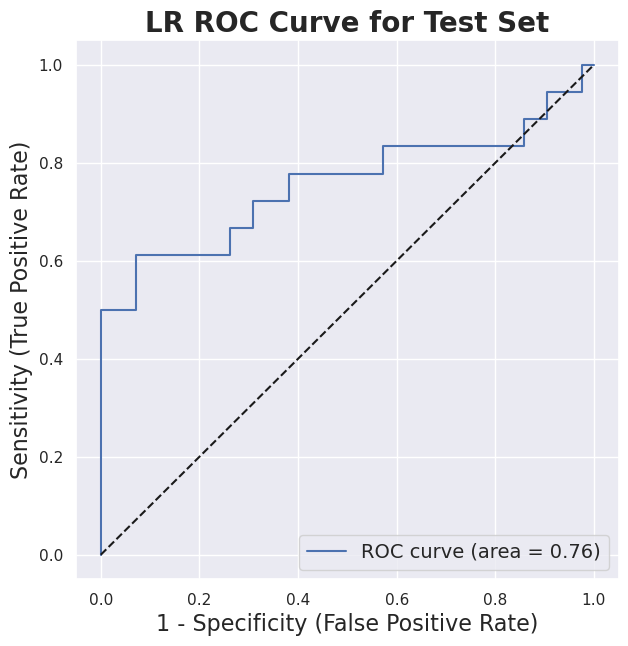

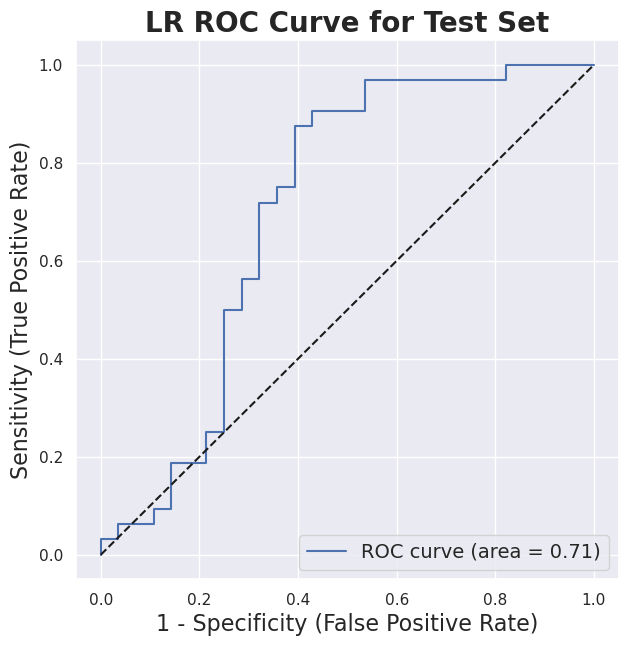

In [42]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    print(f'auc: {roc_auc[i]:.6f}')

print(f"Macro-Averaged AUC: {np.mean(list(roc_auc.values())):.6f}")
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged ROC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7)) ##
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i]) ##
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05]) ##
    plt.ylim([-0.05, 1.05]) ##
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16) ##
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16) ##
    plt.title('LR ROC Curve for Test Set', fontsize=20, fontweight="semibold") ##
    plt.legend(loc="lower right", fontsize=14) ##
    plt.show()

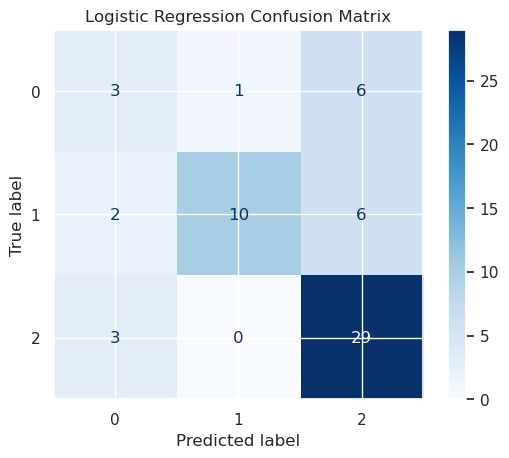

In [40]:
matrix = ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Logistic Regression Confusion Matrix')
plt.show(matrix)
plt.show()

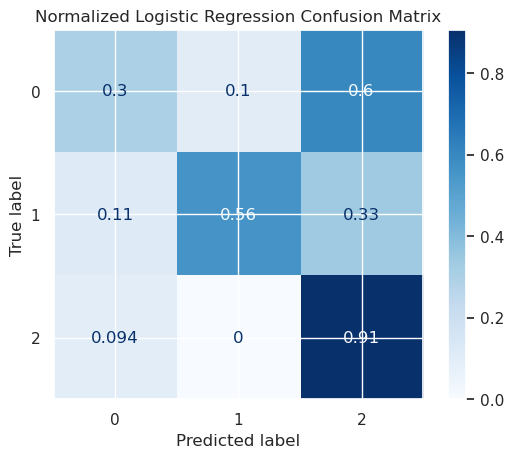

In [41]:
norm_matrix = ConfusionMatrixDisplay.from_estimator(lr_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized Logistic Regression Confusion Matrix')
plt.show(matrix)
plt.show()

In [42]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = []
bootstrapped_npv_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = []
    one_npv = []
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv)
    bootstrapped_npv_scores.append(one_npv)

/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages

KeyboardInterrupt: 

In [ ]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV")
create_ci(bootstrapped_npv_scores, "NPV")

95% Confidence interval for the AUC score for class 0: [0.746 - 0.946]
95% Confidence interval for the AUC score for class 1: [0.543 - 0.892]
95% Confidence interval for the AUC score for class 2: [0.763 - 0.97]
95% Confidence interval for the Accuracy score for class 0: [0.682 - 0.879]
95% Confidence interval for the Accuracy score for class 1: [0.697 - 0.894]
95% Confidence interval for the Accuracy score for class 2: [0.742 - 0.924]
95% Confidence interval for the Specificity score for class 0: [0.712 - 0.911]
95% Confidence interval for the Specificity score for class 1: [0.792 - 0.963]
95% Confidence interval for the Specificity score for class 2: [0.722 - 1.0]
95% Confidence interval for the Precision score for class 0: [0.267 - 0.9]
95% Confidence interval for the Precision score for class 1: [0.222 - 0.786]
95% Confidence interval for the Precision score for class 2: [0.683 - 0.923]
95% Confidence interval for the Recall score for class 0: [0.143 - 0.611]
95% Confidence interva

Feature: 0, Score: -0.81711
Feature: 1, Score: -0.82305
Feature: 2, Score: 0.23678
Feature: 3, Score: -1.44279
Feature: 4, Score: -0.74879
Feature: 5, Score: 0.90894
Feature: 6, Score: 1.94332
Feature: 7, Score: -1.23516
Feature: 8, Score: 0.58942
Feature: 9, Score: -1.05649
Feature: 10, Score: 0.78901
Feature: 11, Score: 0.16106
Feature: 12, Score: 1.03018
Feature: 13, Score: 0.87060
Feature: 14, Score: -1.26062
Feature: 15, Score: 0.17048
Feature: 16, Score: -1.13631
Feature: 17, Score: -2.30473
Feature: 18, Score: 1.95428
Feature: 19, Score: -3.34607
Feature: 20, Score: -3.92874
Feature: 21, Score: 1.73355
Feature: 22, Score: 2.37278
Feature: 23, Score: 1.31868
Feature: 24, Score: 1.31868


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26). If you observe this warning while using RFE or SelectFromModel, use the importance_getter parameter instead.
  warnings.warn(msg, category=FutureWarning)


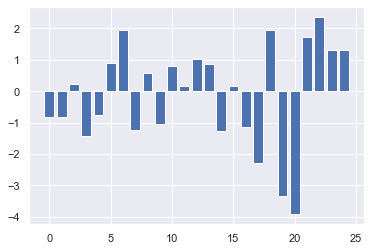

In [ ]:
importance = lr_model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

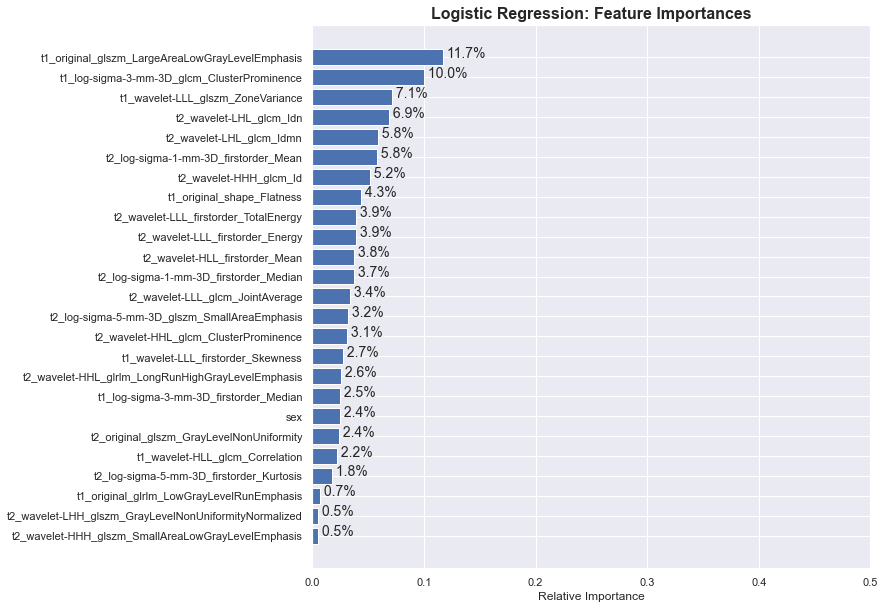

In [ ]:
feature_names = X_test.columns.to_list()
importance = lr_model.coef_[0]
importance = np.abs(importance) / np.sum(np.abs(importance))
indices = np.argsort(importance)

plt.figure(figsize=(10, 10)) ##
plt.title('Logistic Regression: Feature Importances', fontsize=16, fontweight='semibold')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.xlim(0, 0.50) ##
for index, value in enumerate(importance[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

plt.show()

### KNN

#### Grid Search for Hyperparameters

In [43]:
knn_model = KNeighborsClassifier()
grid_param = {'n_neighbors': [3, 5, 7]
}

knn_grid = GridSearchCV(estimator=knn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [46]:
knn_grid.fit(X_train, y_train)
print(knn_grid.best_params_)

{'n_neighbors': 3}


#### Model Performance

In [47]:
knn_model = KNeighborsClassifier(**knn_grid.best_params_)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

In [48]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Precision
WNT 0.14285715
SHH 0.64285713
G34 0.61538464
Macro Avg: 0.46703300
Recall
WNT 0.10000000
SHH 0.50000000
G34 0.75000000
Macro Avg: 0.45000002
F1
WNT 0.11764706
SHH 0.56250000
G34 0.67605633
Macro Avg: 0.45206776
multiclass acc: 0.56666667


In [49]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.14      0.10      0.12        10
           1       0.64      0.50      0.56        18
           2       0.62      0.75      0.68        32

    accuracy                           0.57        60
   macro avg       0.47      0.45      0.45        60
weighted avg       0.54      0.57      0.55        60



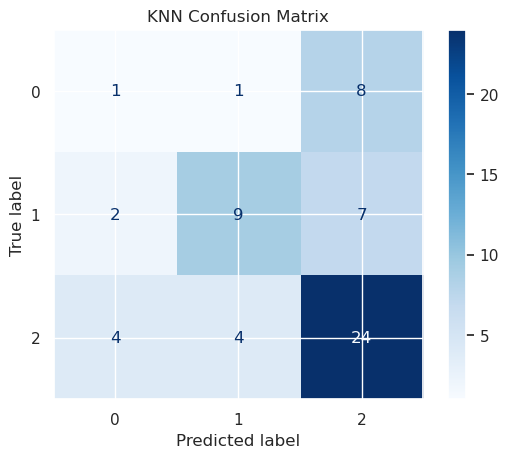

In [50]:
matrix = ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('KNN Confusion Matrix')
plt.show(matrix)
plt.show()

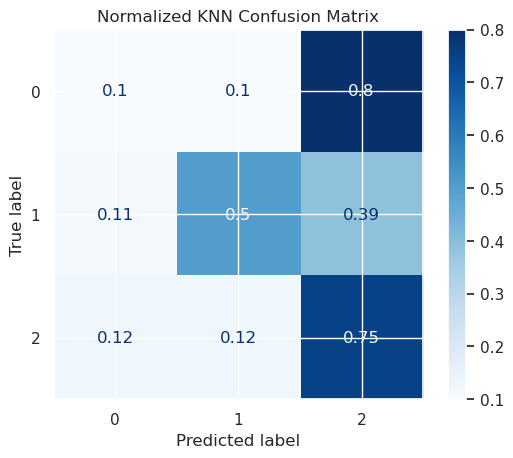

In [51]:
norm_matrix = ConfusionMatrixDisplay.from_estimator(knn_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized KNN Confusion Matrix')
plt.show(matrix)
plt.show()

wnt
Accuracy: 0.75
auc: 0.475000
shh
Accuracy: 0.7666666666666667
auc: 0.725529
g34
Accuracy: 0.6166666666666667
auc: 0.608259
Macro-Averaged AUC: 0.602929
Micro-Averaged AUC: 0.6844444444444444


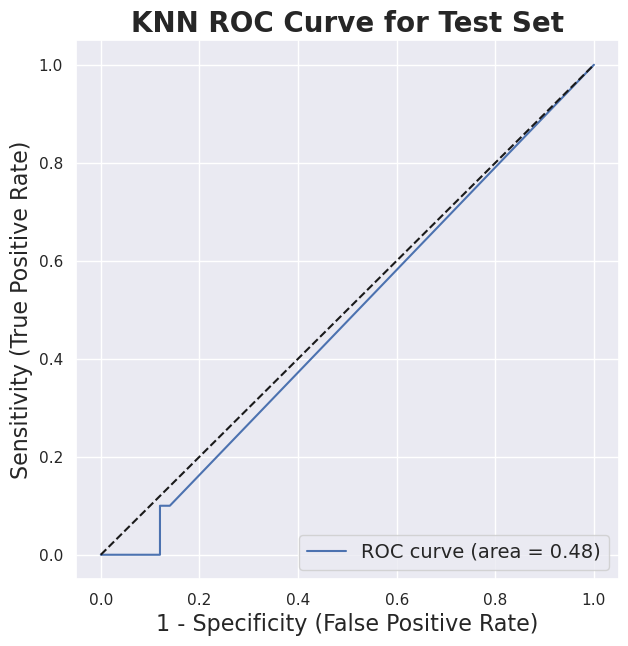

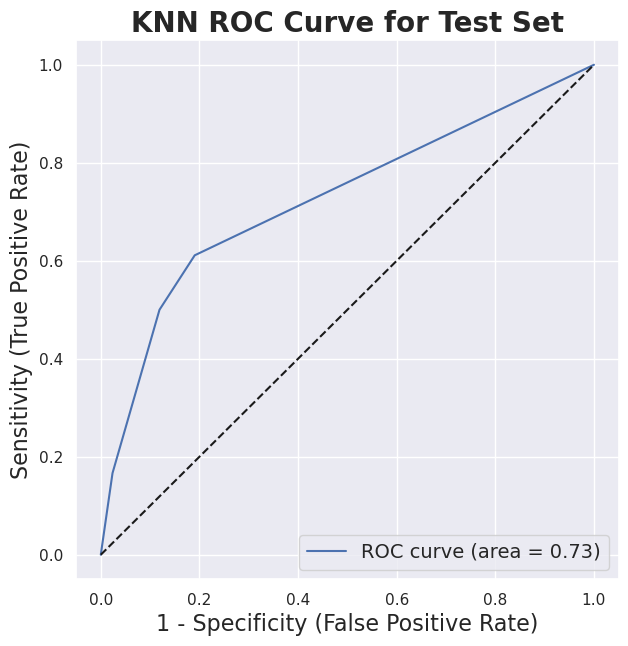

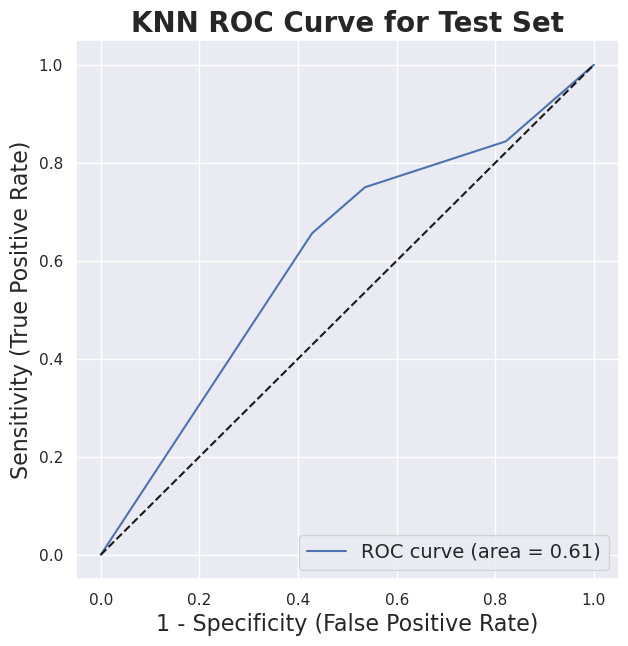

In [53]:
y_score = knn_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2, 3])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    print(f'auc: {roc_auc[i]:.6f}')

print(f"Macro-Averaged AUC: {np.mean(list(roc_auc.values())):.6f}")
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7))
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16)
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16)
    plt.title('KNN ROC Curve for Test Set', fontsize=20, fontweight="semibold")
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

In [54]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = []
bootstrapped_npv_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = []
    one_npv = []
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv)
    bootstrapped_npv_scores.append(one_npv)

KeyboardInterrupt: 

In [ ]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV")
create_ci(bootstrapped_npv_scores, "NPV")

95% Confidence interval for the AUC score for class 0: [0.576 - 0.897]
95% Confidence interval for the AUC score for class 1: [0.577 - 0.879]
95% Confidence interval for the AUC score for class 2: [0.712 - 0.921]
95% Confidence interval for the Accuracy score for class 0: [0.758 - 0.924]
95% Confidence interval for the Accuracy score for class 1: [0.682 - 0.879]
95% Confidence interval for the Accuracy score for class 2: [0.727 - 0.909]
95% Confidence interval for the Specificity score for class 0: [0.833 - 0.981]
95% Confidence interval for the Specificity score for class 1: [0.745 - 0.939]
95% Confidence interval for the Specificity score for class 2: [0.609 - 0.952]
95% Confidence interval for the Precision score for class 0: [0.167 - 0.833]
95% Confidence interval for the Precision score for class 1: [0.300 - 0.857]
95% Confidence interval for the Precision score for class 2: [0.714 - 0.935]
95% Confidence interval for the Recall score for class 0: [0.167 - 0.812]
95% Confidence in

### Random Forest

#### Grid Search for Hyperparameters

In [55]:
rf_model = RandomForestClassifier(random_state = 42)
grid_param = {'n_estimators': [None, 50, 100, 200, 300],
              'max_depth': [1, 2, 3, 4]
}

rf_grid = GridSearchCV(estimator=rf_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [56]:
rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)

/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/base.py", line 600, in _

{'max_depth': 4, 'n_estimators': 200}


#### Model Performance

In [57]:
rf_model = RandomForestClassifier(**rf_grid.best_params_, random_state = 42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.73      0.44      0.55        18
           2       0.62      0.94      0.75        32

    accuracy                           0.63        60
   macro avg       0.45      0.46      0.43        60
weighted avg       0.55      0.63      0.57        60



In [59]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Precision
WNT 0.00000000
SHH 0.72727275
G34 0.62500000
Macro Avg: 0.45075759
Recall
WNT 0.00000000
SHH 0.44444445
G34 0.93750000
Macro Avg: 0.46064815
F1
WNT 0.00000000
SHH 0.55172414
G34 0.75000000
Macro Avg: 0.43390808
multiclass acc: 0.63333333


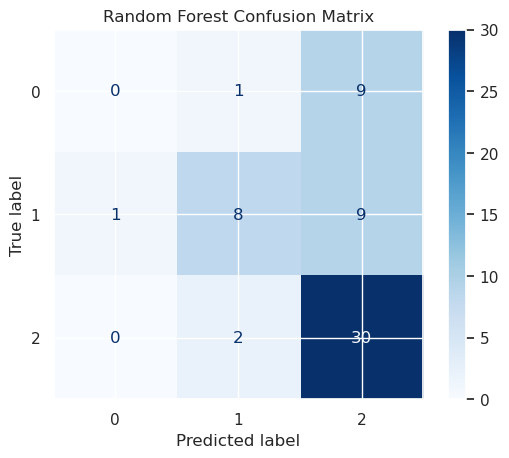

In [60]:
matrix = ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show(matrix)
plt.show()

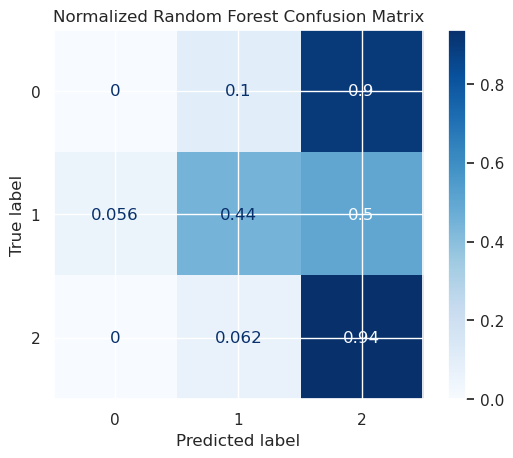

In [61]:
norm_matrix = ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized Random Forest Confusion Matrix')
plt.show(matrix)
plt.show()

wnt
Accuracy: 0.8166666666666667
auc: 0.528000
shh
Accuracy: 0.7833333333333333
auc: 0.726190
g34
Accuracy: 0.6666666666666666
auc: 0.684152
Macro-Averaged AUC: 0.646114
Micro-Averaged AUC: 0.7534722222222222


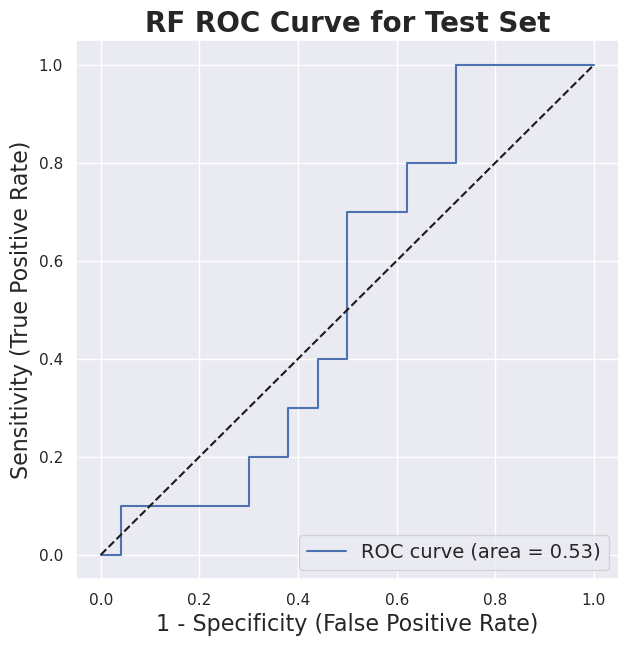

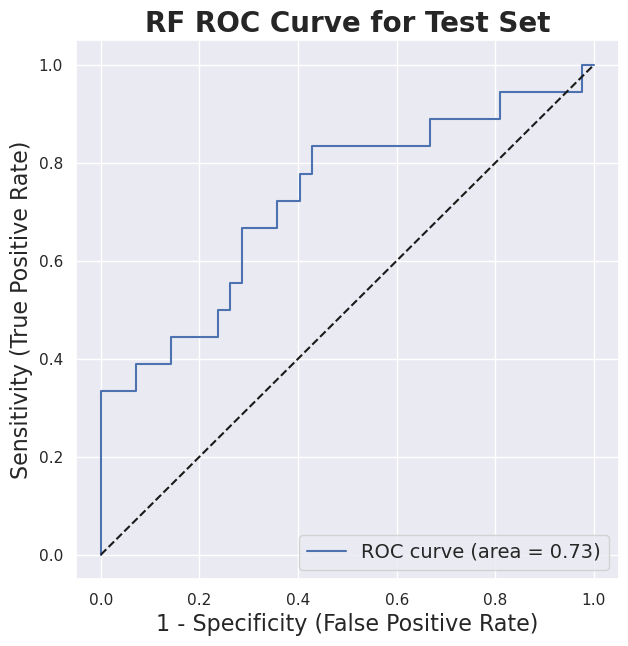

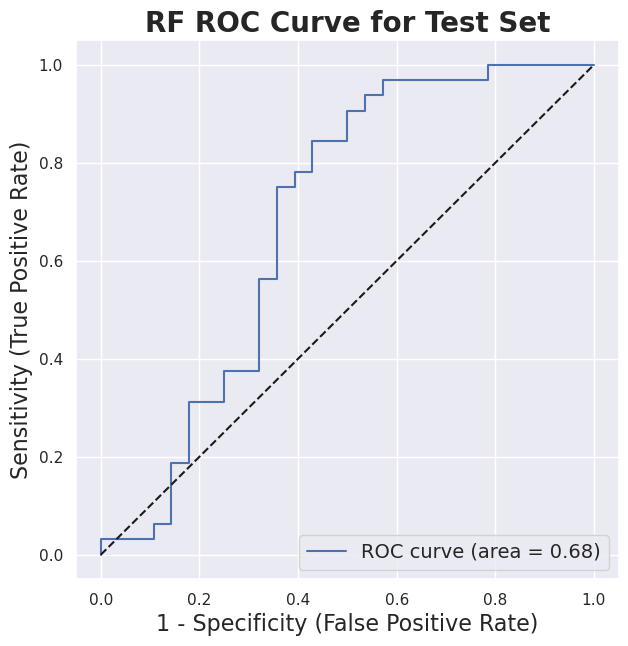

In [65]:
y_score = rf_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2, 3])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    print(f'auc: {roc_auc[i]:.6f}')

print(f"Macro-Averaged AUC: {np.mean(list(roc_auc.values())):.6f}")
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7))
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16)
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16)
    plt.title('RF ROC Curve for Test Set', fontsize=20, fontweight="semibold")
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

In [ ]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] ##
bootstrapped_npv_scores = [] ##

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] 
    one_npv = [] 
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv)
    bootstrapped_npv_scores.append(one_npv)

In [ ]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV")
create_ci(bootstrapped_npv_scores, "NPV")

95% Confidence interval for the AUC score for class 0: [0.711 - 0.95]
95% Confidence interval for the AUC score for class 1: [0.733 - 0.927]
95% Confidence interval for the AUC score for class 2: [0.827 - 0.968]
95% Confidence interval for the Accuracy score for class 0: [0.788 - 0.939]
95% Confidence interval for the Accuracy score for class 1: [0.682 - 0.879]
95% Confidence interval for the Accuracy score for class 2: [0.697 - 0.894]
95% Confidence interval for the Specificity score for class 0: [0.857 - 0.983]
95% Confidence interval for the Specificity score for class 1: [0.766 - 0.945]
95% Confidence interval for the Specificity score for class 2: [0.524 - 0.885]
95% Confidence interval for the Precision score for class 0: [0.167 - 0.833]
95% Confidence interval for the Precision score for class 1: [0.250 - 0.769]
95% Confidence interval for the Precision score for class 2: [0.738 - 0.953]
95% Confidence interval for the Recall score for class 0: [0.200 - 0.889]
95% Confidence int

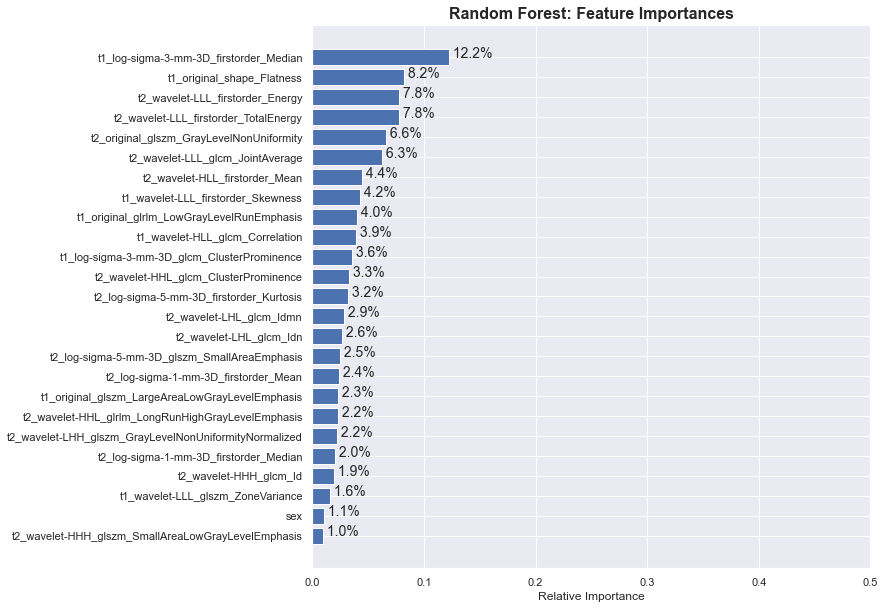

In [ ]:
feature_names = X_test.columns.to_list()
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 10))
plt.title('Random Forest: Feature Importances', fontsize=16, fontweight='semibold')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlim(0, 0.50)
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoost

#### Grid Search for Hyperparameters

In [66]:
xgb_model = XGBClassifier(objective = 'multi:softmax', random_state = 42)
grid_param = {'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [3, 4, 5, 6]
}

xgb_grid = GridSearchCV(estimator=xgb_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [67]:
xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_params_)

{'learning_rate': 0.3, 'max_depth': 3}


#### Model Performance

In [68]:
xgb_model = XGBClassifier(objective = 'multi:softmax', **xgb_grid.best_params_, random_state = 42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [69]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Precision
WNT 0.00000000
SHH 0.85714287
G34 0.58490568
Macro Avg: 0.48068285
Recall
WNT 0.00000000
SHH 0.33333334
G34 0.96875000
Macro Avg: 0.43402779
F1
WNT 0.00000000
SHH 0.47999999
G34 0.72941178
Macro Avg: 0.40313724
multiclass acc: 0.61666667


In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.86      0.33      0.48        18
           2       0.58      0.97      0.73        32

    accuracy                           0.62        60
   macro avg       0.48      0.43      0.40        60
weighted avg       0.57      0.62      0.53        60



/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home-new/function2/miniconda3/envs/mb/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

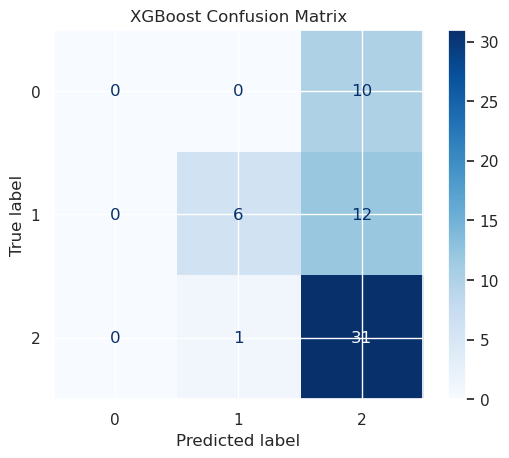

In [71]:
matrix = ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix')
plt.show(matrix)
plt.show()

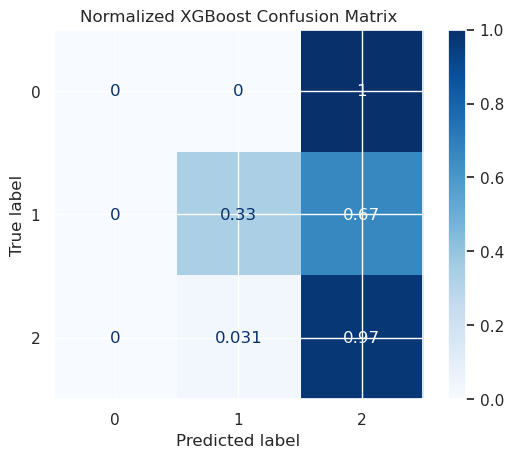

In [72]:
norm_matrix = ConfusionMatrixDisplay.from_estimator(xgb_model, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize = 'true')
plt.title('Normalized XGBoost Confusion Matrix')
plt.show(matrix)
plt.show()

wnt
Accuracy: 0.8333333333333334
auc: 0.490000
shh
Accuracy: 0.7833333333333333
auc: 0.750000
g34
Accuracy: 0.6166666666666667
auc: 0.671875
Macro-Averaged AUC: 0.637292
Micro-Averaged AUC: 0.7479166666666666


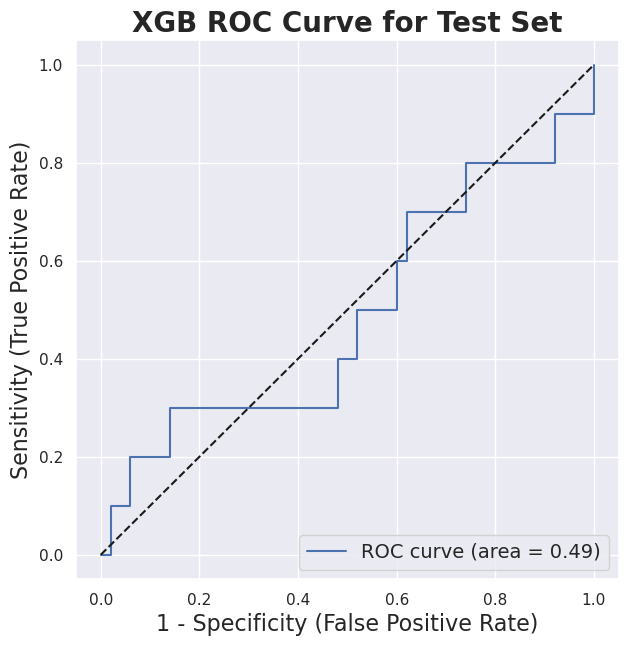

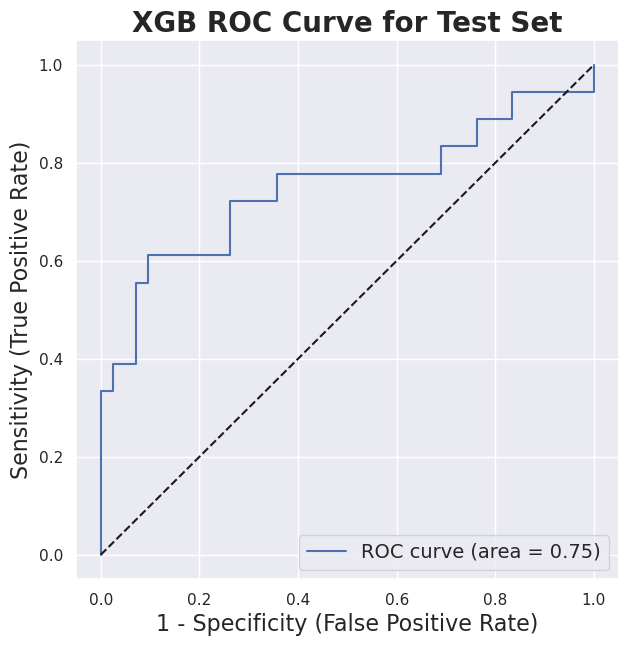

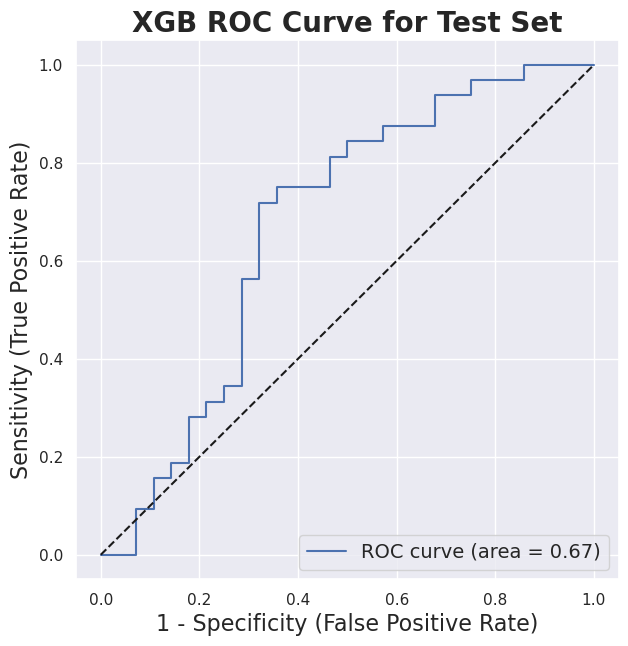

In [74]:
y_score = xgb_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2, 3]) ##

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    print(f'auc: {roc_auc[i]:.6f}')

print(f"Macro-Averaged AUC: {np.mean(list(roc_auc.values())):.6f}")
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7))
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16)
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16)
    plt.title('XGB ROC Curve for Test Set', fontsize=20, fontweight="semibold")
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

In [ ]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = []
bootstrapped_npv_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = []
    one_npv = []
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv)
    bootstrapped_npv_scores.append(one_npv)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being se

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being se

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being se

In [ ]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV")
create_ci(bootstrapped_npv_scores, "NPV")

95% Confidence interval for the AUC score for class 0: [0.899 - 0.994]
95% Confidence interval for the AUC score for class 1: [0.795 - 0.956]
95% Confidence interval for the AUC score for class 2: [0.801 - 0.96]
95% Confidence interval for the Accuracy score for class 0: [0.773 - 0.939]
95% Confidence interval for the Accuracy score for class 1: [0.682 - 0.879]
95% Confidence interval for the Accuracy score for class 2: [0.667 - 0.864]
95% Confidence interval for the Specificity score for class 0: [0.942 - 1.0]
95% Confidence interval for the Specificity score for class 1: [0.719 - 0.92]
95% Confidence interval for the Specificity score for class 2: [0.423 - 0.826]
95% Confidence interval for the Precision score for class 0: [0.000 - 0.5]
95% Confidence interval for the Precision score for class 1: [0.364 - 0.9]
95% Confidence interval for the Precision score for class 2: [0.738 - 0.952]
95% Confidence interval for the Recall score for class 0: [0.000 - 1.0]
95% Confidence interval for

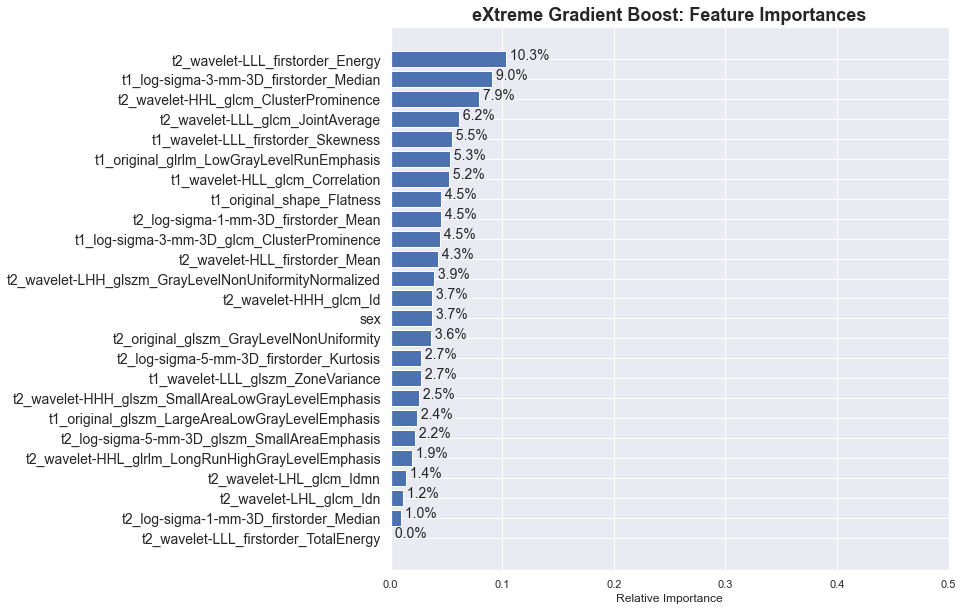

In [ ]:
feature_names = X_test.columns.to_list()
importances = xgb_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 10))
plt.title('eXtreme Gradient Boost: Feature Importances', fontsize=18, fontweight='semibold')
plt.xlim(0, 0.50)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
for index, value in enumerate(importances[indices]):
    plt.text(value, index, " {:.1%}".format(value), fontsize=14)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices], fontsize=14)
plt.xlabel('Relative Importance')

plt.show()

### Neural Net

#### Grid Search for Hyperparameters

In [75]:
nn_model = MLPClassifier(max_iter = 2000, random_state = 42)
grid_param = {'hidden_layer_sizes': [(100, 100, 50), (50, 100, 50), (100, 50, 100)],
              'learning_rate': ['constant', 'invscaling', 'adaptive']
}

nn_grid = GridSearchCV(estimator=nn_model,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

In [76]:
nn_grid.fit(X_train, y_train)
print(nn_grid.best_params_)

{'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant'}


#### Model Performance

In [77]:
nn_model = MLPClassifier(**nn_grid.best_params_, 
                         max_iter = 2000, random_state = 42)
nn_model.fit(X_train, y_train)
y_pred = nn_model.predict(X_test)

In [78]:
y_test_np = y_test.to_numpy()
my_classification_report(y_test_np, y_pred)

Precision
WNT 0.33333334
SHH 0.88888890
G34 0.62500000
Macro Avg: 0.61574072
Recall
WNT 0.10000000
SHH 0.44444445
G34 0.93750000
Macro Avg: 0.49398148
F1
WNT 0.15384616
SHH 0.59259260
G34 0.75000000
Macro Avg: 0.49881291
multiclass acc: 0.65000000


In [79]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.10      0.15        10
           1       0.89      0.44      0.59        18
           2       0.62      0.94      0.75        32

    accuracy                           0.65        60
   macro avg       0.62      0.49      0.50        60
weighted avg       0.66      0.65      0.60        60



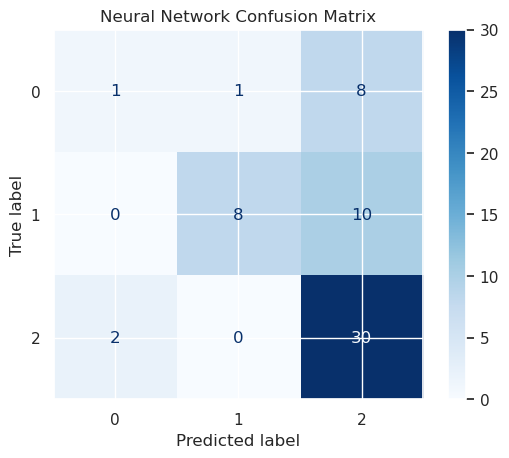

In [80]:
matrix = ConfusionMatrixDisplay.from_estimator(nn_model, X_test, y_test,
                               cmap=plt.cm.Blues)
plt.title('Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

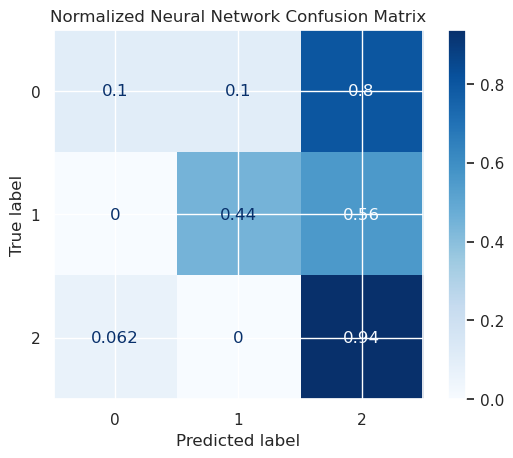

In [81]:
matrix = ConfusionMatrixDisplay.from_estimator(nn_model, X_test, y_test,
                               cmap=plt.cm.Blues,
                               normalize = 'true')
plt.title('Normalized Neural Network Confusion Matrix')
plt.show(matrix)
plt.show()

wnt
Accuracy: 0.8166666666666667
auc: 0.462000
shh
Accuracy: 0.8166666666666667
auc: 0.779101
g34
Accuracy: 0.6666666666666666
auc: 0.628348
Macro-Averaged AUC: 0.623150
Micro-Averaged AUC: 0.7381944444444445


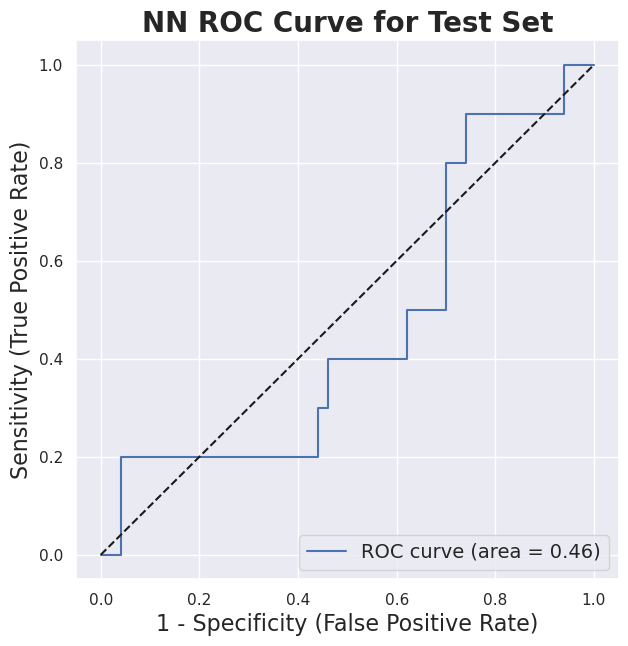

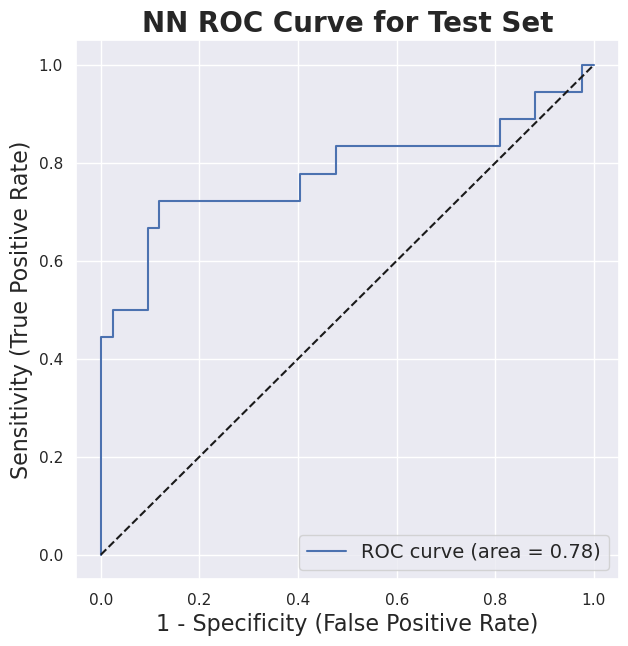

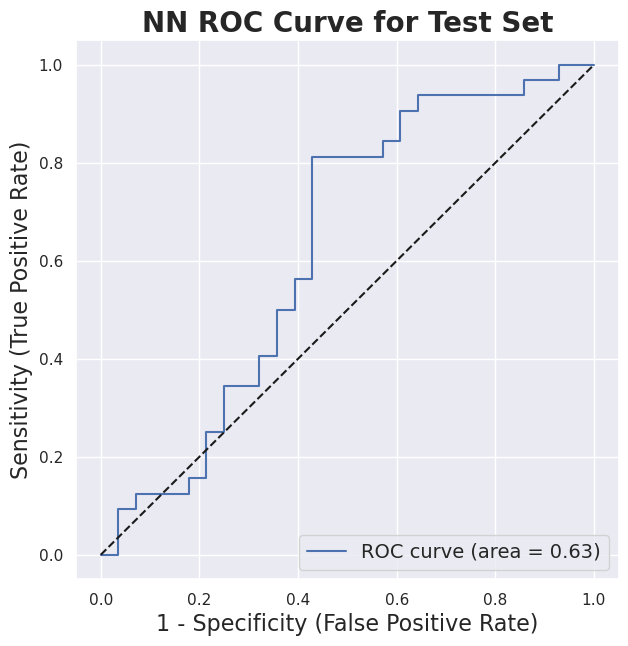

In [83]:
y_score = nn_model.predict_proba(X_test)
y_pred_bin = label_binarize(y_pred, classes = [0, 1, 2, 3])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    acc = accuracy_score(y_pred_bin[:, i], y_test_bin[:, i])
    print(mapping_dict[i])
    print("Accuracy: " + str(acc))
    print(f'auc: {roc_auc[i]:.6f}')

print(f"Macro-Averaged AUC: {np.mean(list(roc_auc.values())):.6f}")
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro-Averaged AUC: " + str(roc_auc["micro"]))
    

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 7))
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=16)
    plt.ylabel('Sensitivity (True Positive Rate)', fontsize=16)
    plt.title('NN ROC Curve for Test Set', fontsize=20, fontweight="semibold")
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

In [ ]:
n_bootstraps = 2000
rng_seed = 42  # control reproducibility
bootstrapped_auc_scores = []
bootstrapped_acc_scores = []
bootstrapped_spec_scores = []
bootstrapped_prec_scores = []
bootstrapped_rec_scores = []
bootstrapped_f_one_scores = []
bootstrapped_ppv_scores = [] 
bootstrapped_npv_scores = [] 

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_test), len(y_test))
    if len(np.unique(y_test.to_numpy()[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    one_roc_auc = []
    one_acc = []
    one_spec = []
    one_prec = []
    one_rec = []
    one_f_one = []
    one_ppv = [] 
    one_npv = [] 
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i][indices], y_score[:, i][indices])
        one_roc_auc.append(auc(fpr[i], tpr[i]))
        one_acc.append(accuracy_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_spec.append(specificity_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_prec.append(precision_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_rec.append(recall_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_f_one.append(f1_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_ppv.append(positive_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
        one_npv.append(negative_pv_score(y_pred_bin[:, i][indices], y_test_bin[:, i][indices]))
    
    bootstrapped_auc_scores.append(one_roc_auc)
    bootstrapped_acc_scores.append(one_acc)
    bootstrapped_spec_scores.append(one_spec)
    bootstrapped_prec_scores.append(one_prec)
    bootstrapped_rec_scores.append(one_rec)
    bootstrapped_f_one_scores.append(one_f_one)
    bootstrapped_ppv_scores.append(one_ppv)
    bootstrapped_npv_scores.append(one_npv)

In [ ]:
create_ci(bootstrapped_auc_scores, "AUC")
create_ci(bootstrapped_acc_scores, "Accuracy")
create_ci(bootstrapped_spec_scores, "Specificity")
create_ci(bootstrapped_prec_scores, "Precision")
create_ci(bootstrapped_rec_scores, "Recall")
create_ci(bootstrapped_f_one_scores, "F1")
create_ci(bootstrapped_ppv_scores, "PPV")
create_ci(bootstrapped_npv_scores, "NPV")

95% Confidence interval for the AUC score for class 0: [0.680 - 0.906]
95% Confidence interval for the AUC score for class 1: [0.563 - 0.856]
95% Confidence interval for the AUC score for class 2: [0.798 - 0.972]
95% Confidence interval for the Accuracy score for class 0: [0.682 - 0.879]
95% Confidence interval for the Accuracy score for class 1: [0.591 - 0.803]
95% Confidence interval for the Accuracy score for class 2: [0.788 - 0.955]
95% Confidence interval for the Specificity score for class 0: [0.807 - 0.966]
95% Confidence interval for the Specificity score for class 1: [0.673 - 0.891]
95% Confidence interval for the Specificity score for class 2: [0.667 - 0.963]
95% Confidence interval for the Precision score for class 0: [0.000 - 0.467]
95% Confidence interval for the Precision score for class 1: [0.111 - 0.636]
95% Confidence interval for the Precision score for class 2: [0.800 - 0.978]
95% Confidence interval for the Recall score for class 0: [0.000 - 0.615]
95% Confidence in